# Tema del workshop: Analizando datos de Google Mapa para definir estrategias comerciales
![](src/logo_utb.png)
![](src/logo_etd.png)
## Facilitador
**Fernando Salcedo Mejía, Eco Msc.**
Profesor de tiempo completo. Escuela de transformación digital. Universidad Tecnológica de Bolívar.
28-29 de enero de 2026

# 1. Desafío a superar usando datos

Somos una cadena de cafeterías en crecimiento en la ciudad de **Cartagena**. Tenemos presupuesto para abrir una nueva sucursal.
La inmobiliaria nos ofrece 3 locales candidatos. 
- Local Bocagrande: Cl. 7 #2-71, Cartagena de Indias, Bolívar
- Local Manga: 09, Cra. 22 #27, Manga, Cartagena de Indias, Bolívar
- Local Transversal 54: 30-266, Tv. 54, Tacarena, Cartagena de Indias, Bolívar

**¿Qué local elegir acorde a la potencialidad de clientes que puedan tener según ubicación?**


# 2. Extracción de datos de Google Mapa

- Uso de la API de Google Maps Services para Python
- Extracción de datos relevantes (ubicaciones, reseñas, horarios, etc.)
**Documentación útil**:
[Google Maps API](https://developers.google.com/maps/documentation)
[Python Client for Google Maps Services](https://github.com/googlemaps/google-maps-services-python)

## 1.1 Configuración y librerías necesarias

In [1]:
# Instalar dependencias (descomentar anter de correr)
# !pip install -r requirements.txt

# Librerias a utilizar
import googlemaps
import folium
from datetime import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt

# Carga de tokens desde archivo JSON
with open("tokens.json") as f:
   INFO = json.load(f)
   API_KEY = INFO['API_GMAPS']

# Inicializacion de la API de Google Maps
gmaps_client = googlemaps.Client(key=API_KEY) # API de Google Maps

## 2.1. Conversión de direcciones a coordenadas geográficas usando la API de Geocoding de Google Maps

In [2]:
# Direcciones de los locales de interés
locales_cafeteria = {
    "Local Bocagrande": "Cl. 7 #2-71, Cartagena de Indias, Bolívar",
    "Local Manga": "09, Cra. 22 #27, Manga, Cartagena de Indias, Bolívar",
    "Local Transversal 54": "30-266, Tv. 54, Tacarena, Cartagena de Indias, Bolívar"
}

# Usar la API de Google Maps para obtener las coordenadas de los locales
coordenadas_locales = {} # Diccionario para almacenar las coordenadas

# Por cada dirección, obtener las coordenadas para usarla en el mapa
for nombre, direccion in locales_cafeteria.items():
    geocode_result = gmaps_client.geocode(direccion)
    # Si hay resultados, extraer latitud y longitud
    if geocode_result:
        latitud = geocode_result[0]['geometry']['location']['lat']
        longitud = geocode_result[0]['geometry']['location']['lng']
        # Guardar las coordenadas en el diccionario
        coordenadas_locales[nombre] = (latitud, longitud)

print("Coordenadas de los locales de cafetería:")
for nombre, coords in coordenadas_locales.items():
    print(f"{nombre}: {coords}")

Coordenadas de los locales de cafetería:
Local Bocagrande: (10.4018207, -75.5555313)
Local Manga: (10.4126937, -75.5353219)
Local Transversal 54: (10.3923494, -75.4858366)


## 2.2. Representación de los locales candidatos en un mapa interactivo usando mapa interactivo de Folium

In [3]:
# Mapa de Cartagena de Indias
coordenadas_cartagena = (10.391049, -75.479426) # Coordenadas centrales de Cartagena
mapa_cartagena = folium.Map(location=coordenadas_cartagena, zoom_start=13) # Crear el mapa centrado en Cartagena

# Agregar marcadores para cada local de cafetería
for nombre, coords in coordenadas_locales.items():
    folium.Marker(
        location=coords, # Coordenadas del marcador
        popup=nombre, # Texto emergente al hacer clic
        icon=folium.Icon(color='blue', icon='coffee', prefix='fa') # Icono personalizado de cafetería
    ).add_to(mapa_cartagena) # Agregar el marcador al mapa principal de Cartagena
# Mostrar el mapa
mapa_cartagena

## 3.1 Búsqueda de lugares cercanos : Consulta API Google Maps Places Nearby y extracción de los datos

In [4]:
# Lugares cercanos a cada local de cafetería
radio_busqueda = 500 # Radio de búsqueda en metros
# Tipo de lugar a buscar
# SUMAN (+10 pts)
generadores_trafico_personas = ['point_of_interest', 'bus_station', 'lodging',
                                 'university', 'gym', 'bank', 'hospital', 'library']

# 2. Generadores que SUMAN (+5 pts)
generadores_trafico_comercial = ['shopping_mall', 'store', 'restaurant']

# 3. Competencia que RESTA (-20 pts)
competencia_directa = ['cafe', 'bakery']

# Agrupar en un solo listado
tipos_lugares = {'trafico_personas' : generadores_trafico_personas,
                 'trafico_comercial' : generadores_trafico_comercial,
                 'competidores' : competencia_directa}

# Guardar los lugares cercanos encontrados en una lista vacía
lugares_cercanos = []

# Buscar lugares cercanos para cada local de cafetería
for nombre_local, coords_local in coordenadas_locales.items():
    for categoria, tipos in tipos_lugares.items():
        for tipo in tipos:
            # Realizar la búsqueda de lugares cercanos usando la API de Google Maps
            places_result = gmaps_client.places_nearby(location=coords_local,
                                                       radius=radio_busqueda,
                                                       type=tipo)
            # Agregar los resultados a la lista correspondiente
            # Aqui extraemos la información relevante de cada lugar encontrado
            for lugar in places_result.get('results', []):
                lugar_info = {
                    'nombre_local_candidato' : nombre_local,
                    'categoria_analisis' : categoria,
                    'nombre_vecino': lugar.get('name'),
                    'lat_vecino': lugar['geometry']['location']['lat'],
                    'lng_vecino': lugar['geometry']['location']['lng'],
                    'direccion': lugar.get('vicinity', 'N/A'),
                    'rating': lugar.get('rating', 'N/A'),
                    'reviews_total': lugar.get('user_ratings_total', 0)
                    }
                lugares_cercanos.append(lugar_info)

# Convertir la lista de lugares cercanos a un DataFrame de pandas
df_lugares_cercanos = pd.DataFrame(lugares_cercanos)

# Imprimir las primeras filas del DataFrame
print("\nLugares cercanos encontrados:")
df_lugares_cercanos


Lugares cercanos encontrados:


,nombre_local_candidato,categoria_analisis,nombre_vecino,lat_vecino,lng_vecino,direccion,rating,reviews_total
0,Local Bocagrande,trafico_personas,Hotel Capilla del Mar,10.404264,-75.555329,Carrera 1 #8 - 12,4.5,5827
1,Local Bocagrande,trafico_personas,Almirante Cartagena Hotel,10.400890,-75.558102,Carrera 2 #Calle 6 Esquina,4.5,5687
2,Local Bocagrande,trafico_personas,Regatta Cartagena,10.400647,-75.558904,"Carrera 1, Avenida Malecón #5-82",4.1,2020
3,Local Bocagrande,trafico_personas,Cartagena Millennium,10.402997,-75.555559,Carrera 2 #7-135,4.3,321
4,Local Bocagrande,trafico_personas,Costa Del Sol,10.405925,-75.554044,Carrera 1 #9-18,3.1,3681
...,...,...,...,...,...,...,...,...
524,Local Transversal 54,competidores,Laura's Cakes Cartagena,10.395004,-75.487885,Carrera 65A #3147,4.6,9
525,Local Transversal 54,competidores,Mundo Pan,10.393651,-75.482610,mz 15 #lt 30,5,3
526,Local Transversal 54,competidores,Panadería Rocapan,10.392543,-75.482279,"Mz.36 Lt.1, Calle 31 #S/N",4.2,19
527,Local Transversal 54,competidores,Panaderia Pasteleria PAN PARE PAN.,10.392498,-75.482178,bomba el amaparo,4.3,245


## 3.2 Análisis exploratorio de datos (EDA) de los lugares cercanos


Resumen de lugares cercanos por categoría:
categoria_analisis      competidores  trafico_comercial  trafico_personas
nombre_local_candidato                                                   
Local Bocagrande                  32                 48                92
Local Manga                       36                 42                88
Local Transversal 54              39                 57                95


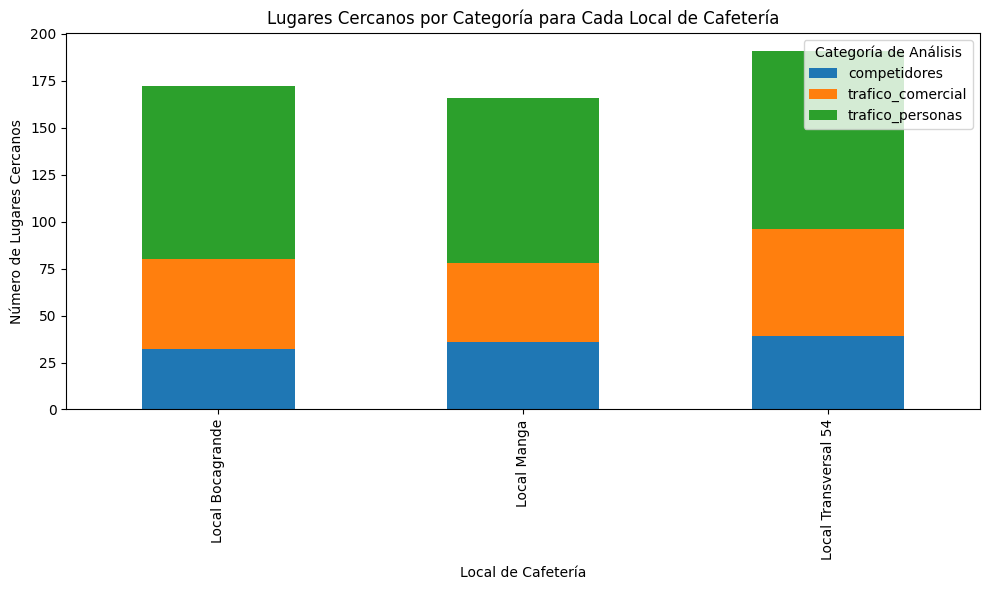

In [5]:
# Resumen de lugares cercanos por categoría
resumen_categorias = df_lugares_cercanos.groupby(['nombre_local_candidato', 'categoria_analisis']).size().unstack(fill_value=0)
print("\nResumen de lugares cercanos por categoría:")
print(resumen_categorias)

# Visualización de los resultados en un gráfico de barras
resumen_categorias.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Lugares Cercanos por Categoría para Cada Local de Cafetería')
plt.xlabel('Local de Cafetería')
plt.ylabel('Número de Lugares Cercanos')
plt.legend(title='Categoría de Análisis')
plt.tight_layout()
plt.show()


Resumen de lugares cercanos por número de reseñas:
nombre_local_candidato
Local Bocagrande        131369
Local Transversal 54     82777
Local Manga               5902
Name: reviews_total, dtype: int64


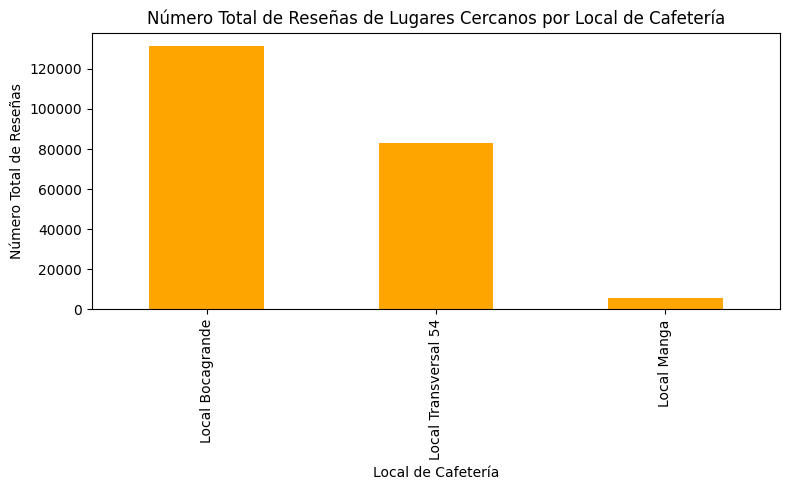

In [6]:
# Resumen de lugares cercanos por número de reseñas (reviews)
resumen_reviews = df_lugares_cercanos.groupby('nombre_local_candidato')['reviews_total'].sum()
resumen_reviews = resumen_reviews.sort_values(ascending=False)
print("\nResumen de lugares cercanos por número de reseñas:")
print(resumen_reviews)

# Visualización de los resultados en un gráfico de barras
resumen_reviews.plot(kind='bar', figsize=(8, 5), color='orange')
plt.title('Número Total de Reseñas de Lugares Cercanos por Local de Cafetería')
plt.xlabel('Local de Cafetería')
plt.ylabel('Número Total de Reseñas')
plt.tight_layout()
plt.show()


Grandes competidores encontrados cerca de los locales de cafetería:
    nombre_local_candidato categoria_analisis  \
141       Local Bocagrande       competidores   
147       Local Bocagrande       competidores   
148       Local Bocagrande       competidores   
155       Local Bocagrande       competidores   
159       Local Bocagrande       competidores   
165       Local Bocagrande       competidores   
493   Local Transversal 54       competidores   
502   Local Transversal 54       competidores   

                            nombre_vecino  lat_vecino  lng_vecino  \
141           Juan Valdez Café La Mansión   10.403363  -75.554154   
147               Café Quindío Bocagrande   10.402134  -75.555892   
148              Juan Valdez - Bocagrande   10.402267  -75.556153   
155              Starbucks Av. San Martín   10.403776  -75.554939   
159                                   OMA   10.399748  -75.558880   
165              Starbucks Av. San Martín   10.403776  -75.554939   
493  J

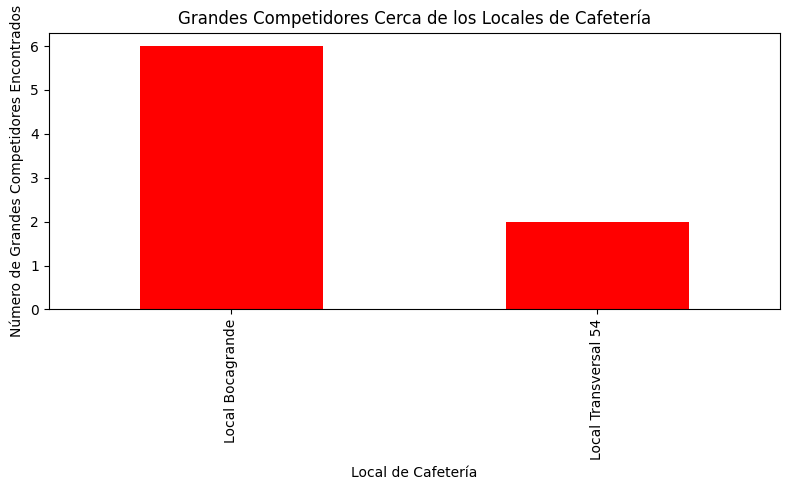

In [7]:
# Resumen de lugares cercanos por grandes competidores
grandes_competidores = ["Juan Valdez", "OMA", "Starbucks", "Café Quindío"]

# Filtrar el DataFrame para encontrar grandes competidores usando expresión regular
df_competidores = df_lugares_cercanos[
    (df_lugares_cercanos['nombre_vecino'].str.contains('|'.join(grandes_competidores), case=True, na=False)) &
    (df_lugares_cercanos['categoria_analisis'] == 'competidores')
] 

# Imprimir los grandes competidores encontrados
print("\nGrandes competidores encontrados cerca de los locales de cafetería:")
print(df_competidores)

# Imprimir resumen grandes competidores encontrados por local de cafetería
resumen_competidores = df_competidores['nombre_local_candidato'].value_counts()
resumen_competidores = resumen_competidores.sort_values(ascending=False)
print("\nResumen de grandes competidores encontrados por local de cafetería:")
print(resumen_competidores)

# Visualización de los grandes competidores en un gráfico de barras
competidores_count = df_competidores['nombre_local_candidato'].value_counts()
competidores_count.plot(kind='bar', figsize=(8, 5), color='red')
plt.title('Grandes Competidores Cerca de los Locales de Cafetería')
plt.xlabel('Local de Cafetería')
plt.ylabel('Número de Grandes Competidores Encontrados')
plt.tight_layout()
plt.show()

## 4.1 Puntaje de viabilidad comercial para cada local

$$Viabilidad = \text{Número de generadores de tráfico} \times 10 + \frac{\text{Número de reviews}}{100} - \text{Número de competidores} \times 20$$


Detalle de puntajes por dimensión:
     Local de Cafetería  Puntaje Tráfico Personas  Puntaje Tráfico Comercial  \
0      Local Bocagrande                       920                        480   
1           Local Manga                       880                        420   
2  Local Transversal 54                       950                        570   

   Puntaje Reviews  Puntaje Competencia Directa  Puntaje Final  
0          1313.69                         -640        2073.69  
1            59.02                         -720         639.02  
2           827.77                         -780        1567.77  


Text(0.5, 0, 'Local de Cafetería')

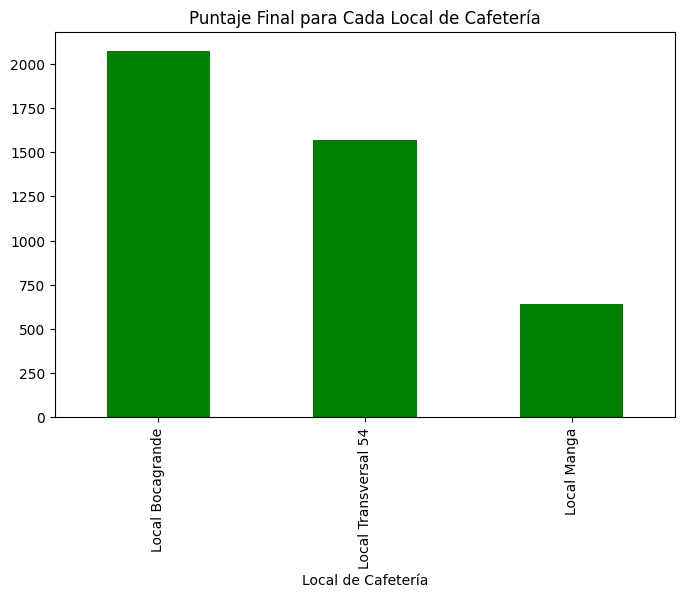

In [8]:
# Puntaje por generadores de tráfico de personas (+10 pts)
puntaje_trafico_personas = 10
puntaje_trafico_comercial = 10
# Puntaje por reviews  1 punto por cada 100 reviews
puntaje_reviews = 1/100
# Puntaje por competencia directa (-20 pts)
puntaje_competencia = -20

# Calcular el puntaje total para cada local de cafetería
score_trafico_personas = resumen_categorias['trafico_personas'] * puntaje_trafico_personas
score_trafico_comercial = resumen_categorias['trafico_comercial'] * puntaje_trafico_comercial
score_rewiews = resumen_reviews * puntaje_reviews
score_competencia = resumen_categorias['competidores'] * puntaje_competencia

# Sumar todos los puntajes para obtener el puntaje final
puntaje_final = score_trafico_personas + score_trafico_comercial + score_rewiews + score_competencia

# Detalle de puntajes por dimensión
lista_puntajes = []
for local in resumen_categorias.index:
    lista_puntajes.append({
        'Local de Cafetería': local,
        'Puntaje Tráfico Personas': score_trafico_personas[local],
        'Puntaje Tráfico Comercial': score_trafico_comercial[local],
        'Puntaje Reviews': score_rewiews[local],
        'Puntaje Competencia Directa': score_competencia[local],
        'Puntaje Final': puntaje_final[local]
    })

detalle_puntajes = pd.DataFrame(lista_puntajes)
print("\nDetalle de puntajes por dimensión:")
print(detalle_puntajes)

# Visualización del puntaje final en un gráfico de barras
puntaje_final = puntaje_final.sort_values(ascending=False)
puntaje_final.plot(kind='bar', figsize=(8, 5), color='green')
plt.title('Puntaje Final para Cada Local de Cafetería')
plt.xlabel('Local de Cafetería')


## 4.2. Visualizar el puntaje final y todos los marcadores en el mapa de Cartagena

In [14]:
# Crear el mapa centrado en Cartagena con marcadores de puntaje
mapa_cartagena_marcadores = folium.Map(location=coordenadas_cartagena, zoom_start=13) 

# Agregar marcadores para cada local de cafetería
for nombre, coords in coordenadas_locales.items():
    nombre_score = puntaje_final.get(nombre, 0)
    nombre_con_score = f"{nombre} - Puntaje: {nombre_score}"
    folium.Marker(
        location=coords, # Coordenadas del marcador
        popup=nombre_con_score, # Texto emergente al hacer clic
        icon=folium.Icon(color='blue', icon='coffee', prefix='fa'), # Icono personalizado de cafetería
    ).add_to(mapa_cartagena_marcadores)

# Agregar un circulo alrededor de cada local de cafetería para indicar el radio de búsqueda
for nombre, coords in coordenadas_locales.items():
    folium.Circle(
        location=coords,
        radius=radio_busqueda,
        color='cornflowerblue',
        fill=True,
        fill_opacity=0.1,
        stroke=False
    ).add_to(mapa_cartagena_marcadores)


# Marcadores de lugares cercanos a la cafetería en el mapa por color
for idx, row in df_lugares_cercanos.iterrows():
    if row['categoria_analisis'] == 'trafico_personas':
        color_icono = 'green'
        icon_name = 'briefcase'
    elif row['categoria_analisis'] == 'trafico_comercial':
        color_icono = 'orange'
        icon_name = 'cart-shopping'
    else:  # competencia
        color_icono = 'red'
        icon_name = 'coffee'
    
    folium.Marker(
        location=(row['lat_vecino'], row['lng_vecino']),
        popup=f"{row['nombre_vecino']} ({row['categoria_analisis']})",
        icon=folium.Icon(color=color_icono, icon=icon_name, prefix='fa')
    ).add_to(mapa_cartagena_marcadores)

# Mostrar el mapa con los lugares cercanos
mapa_cartagena_marcadores

## 5. Conclusiones y recomendaciones
### Selección del local con mayor puntaje de viabilidad comercial : Local Bocagrande : Cl. 7 #2-71, Cartagena de Indias, Bolívar
### Justificación basada en datos extraídos y analizados :
- Mayor número de generadores de tráfico cercanos
- Buenas reseñas y opiniones de los usuarios
- Hay competencia de como Juan Valdez pero el volumen potencial de ventas compensa en le puntaje final
### Sugerencias finales para la toma de decisiones comerciales :
- Realizar un análisis financiero detallado del local seleccionado
- Considerar factores adicionales como costos de alquiler, accesibilidad y demografía local
- Implementar estrategias de marketing basadas en los datos obtenidos para maximizar el potencial del nuevo local
